# Interactive Analysis Notebook

In [1]:
# Import packages and dependencies
import importlib
import time
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgb
import os
from pathlib import Path
from pipeline import pipeline
from analysis import *
import figure
from subject_analysis import Dataset, Cohort, Subject
import compute_ld_centering

In [2]:
RESEARCH_DIR = Path("/Users/anantajit/Documents/UCSF")
COHORT = \
    "LD/FullDataset"
SOURCE_FILE = \
    "raw_dataset.mat"
DEMOGRAPHICS_FILE = \
    "demographics.csv"
SOURCE_STRUCT = \
    "LD_Patients"

INPUT_PATH = RESEARCH_DIR / "datasets" / COHORT
DEMOGRAPHICS_PATH = INPUT_PATH / DEMOGRAPHICS_FILE
OUTPUT_PATH = RESEARCH_DIR / "results" / COHORT
CACHE_PATH = RESEARCH_DIR / "results" / COHORT / "cache"

FORCE_ANALYSIS = False

DPI = 300
plot_settings = {
    "plot_order": ["Controls", "LD Patients"],
    "colormap": {
        "LOWER": "#1f77b4",
        "CENTRAL": "#ff7f0e",
        "UPPER": "#2ca02c"
    },

    "error-color": "black",
    "line-width": 1.5,
    "error-cap-size": 10,
    "error-line-style": '',
    "font_size": 12,
    "font_family": "Times New Roman",

    "motion_lw": 2.0,
    "motion_alpha": 0.75,

    "annotation_padding": 2
}

trimming_pipeline = [
        trim_by_subject_trial_count,  # remove subjects with <25 trials
        trim_by_group_initial_pitch_distribution,  # remove trials which have initial pitch deviation >2std from mean
        (trim_by_subject_name,
         dict(exclude=[("LD Patients", "20170516"), ("LD Patients", "20170307")])
         ),
        rename_subjects_by_group  # is this strictly necessary?
    ]

In [3]:
ld = Dataset(str(INPUT_PATH / SOURCE_FILE), SOURCE_STRUCT)
demographics = pd.read_csv(DEMOGRAPHICS_PATH)

if FORCE_ANALYSIS or not (Path(CACHE_PATH) / "centering_data.csv").is_file():
    compute_ld_centering.gen_centering_csv(dataset=ld, OUTPUT_PATH=OUTPUT_PATH, CACHE_PATH=CACHE_PATH)

if FORCE_ANALYSIS or not (Path(CACHE_PATH / "trimmed_dataset.csv").is_file()
                          and Path(CACHE_PATH / "peripheral_dataset.csv").is_file()):
    compute_ld_centering.gen_centering_analysis(demographics=demographics, CACHE_PATH=CACHE_PATH)

# TODO: move plotting code into more accessible cells here
# compute_ld_centering.gen_group_figures(dataset=ld, CACHE_PATH=CACHE_PATH, OUTPUT_PATH=OUTPUT_PATH, plot_settings=plot_settings, DPI=DPI)

# compute_ld_centering.gen_subject_figures(dataset=ld, CACHE_PATH=CACHE_PATH, OUTPUT_PATH=OUTPUT_PATH, plot_settings=plot_settings, DPI=DPI)

output_dataset = pd.read_csv(CACHE_PATH / "peripheral_dataset.csv")

plot_settings["colormap"] = {
    "Controls": {
        "UPPER": "#1f77b4",
        # "CENTRAL": "#ff7f0e",
        "LOWER": "#2ca02c"
    },
    "LD Patients": {
        "UPPER": "#d62728",
        # "CENTRAL": "#9467bd",
        "LOWER": "#8c564b"
    }
}


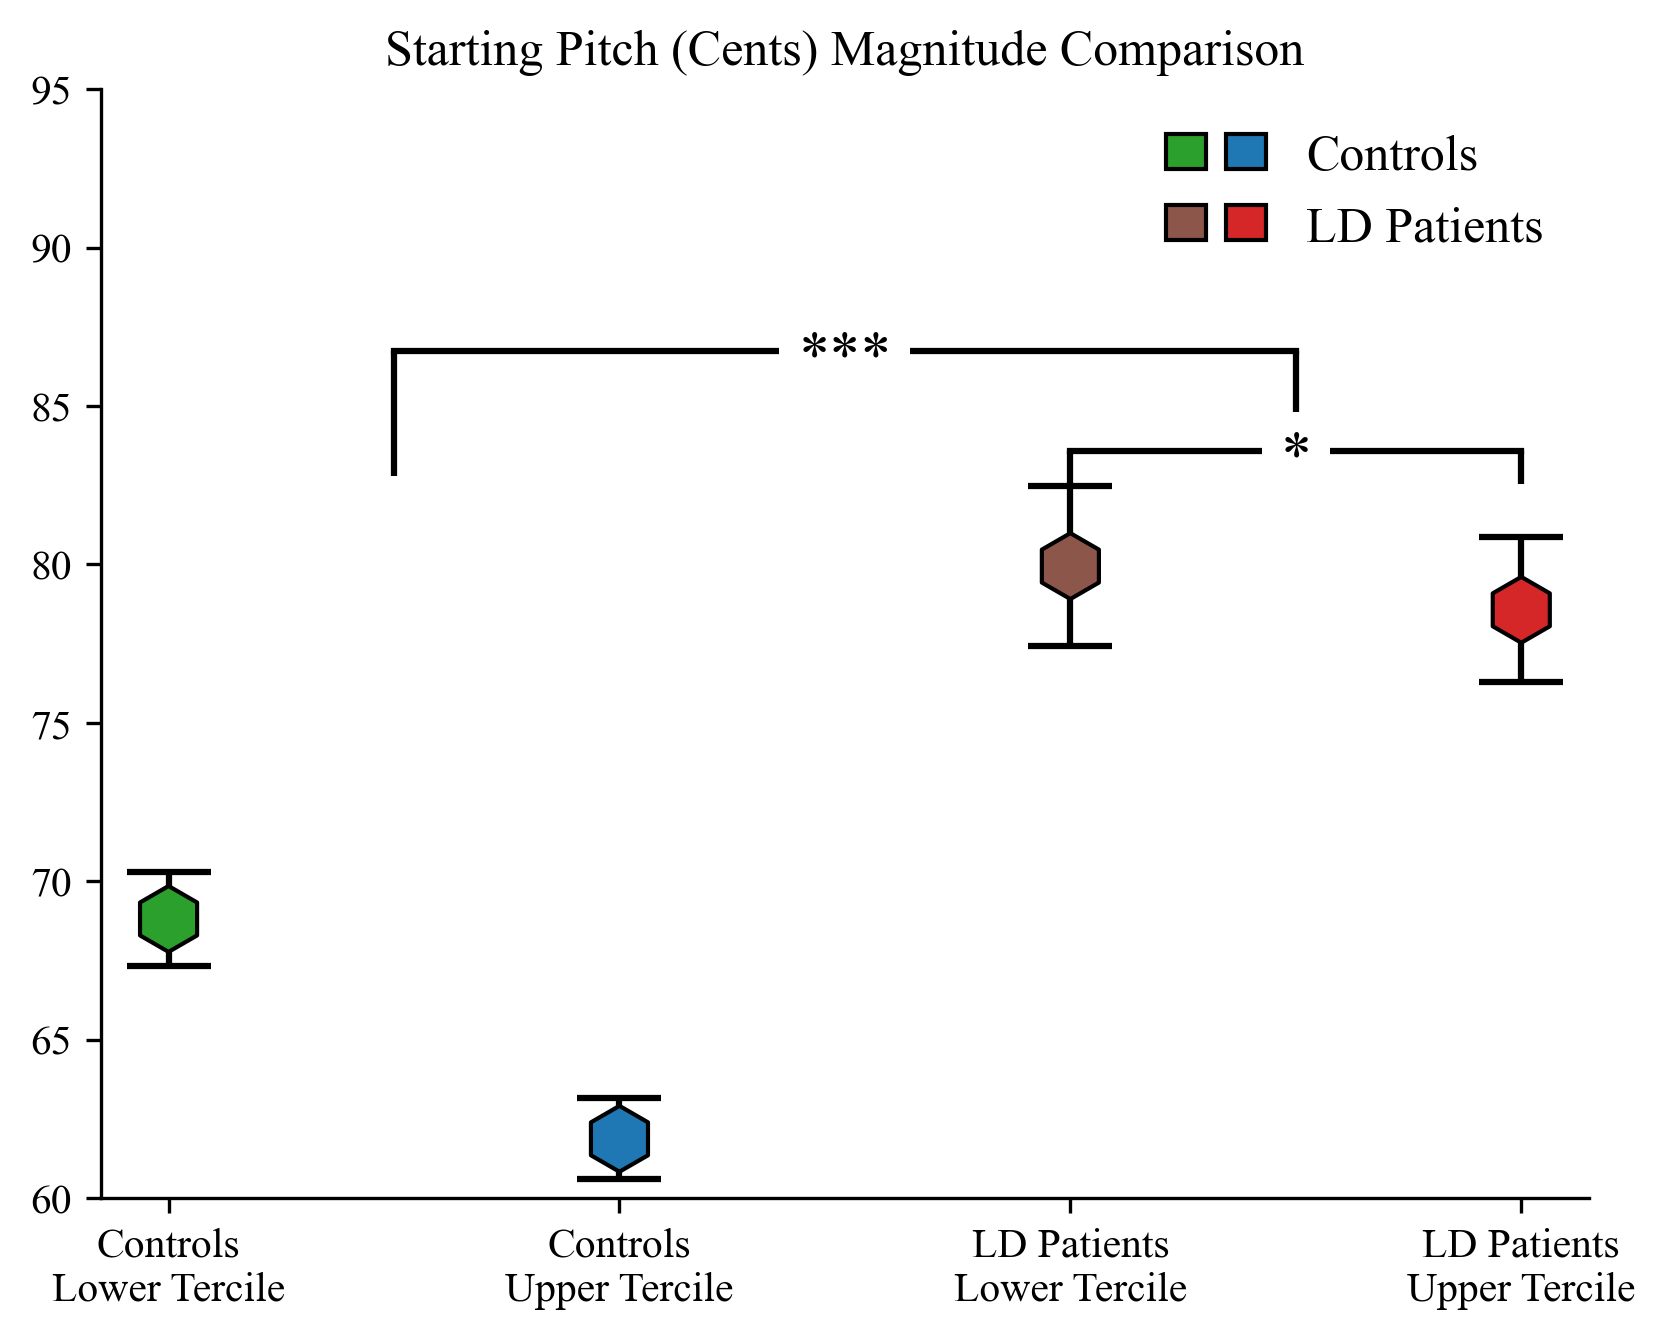

In [4]:
importlib.reload(figure)
matplotlib.rcParams['font.family'] = 'Times New Roman'

# set the font to times new roman
output_dataset = pd.read_csv(CACHE_PATH / "peripheral_dataset.csv")
output_dataset["Centering Class"] = (output_dataset["Centering (Cents)"]
                                     .apply(lambda x: "Centering" if x > 0 else "Anti-centering"))
output_dataset["Overshoot"] = np.abs(output_dataset["Pitch Movement"]) > np.abs(output_dataset["Centering (Cents)"])


fig, ax = plt.subplots(1, 1, dpi=300)
figure.group_pitch_magnitude_comparison(output_dataset, fig, plot_settings, ("Controls", "LD Patients"), label_map={
    ("Controls", "UPPER"): "Controls\nUpper Tercile",
    ("Controls", "CENTRAL"): "Controls\nCentral Tercile",
    ("Controls", "LOWER"): "Controls\nLower Tercile",
    ("LD Patients", "UPPER"): "LD Patients\nUpper Tercile",
    ("LD Patients", "CENTRAL"): "LD Patients\nCentral Tercile",
    ("LD Patients", "LOWER"): "LD Patients\nLower Tercile"
})
# @Rabab: edit these significance bars
figure.significance_bar(ax, 2, 3, max(ax.get_ylim()), display_string= "*")
# optional: adds a grouping bracket for controls (without significance)
# figure.significance_bar(ax, 0, 1, max(ax.get_ylim()) - 1.3, display_string= "")
figure.significance_bar(ax, 0.5, 2.5, max(ax.get_ylim()) + 2, display_string= "***", marker_size=30)
ax.set_ylim((60, 95))
plt.show()


(0.0, 56.53415358828664)

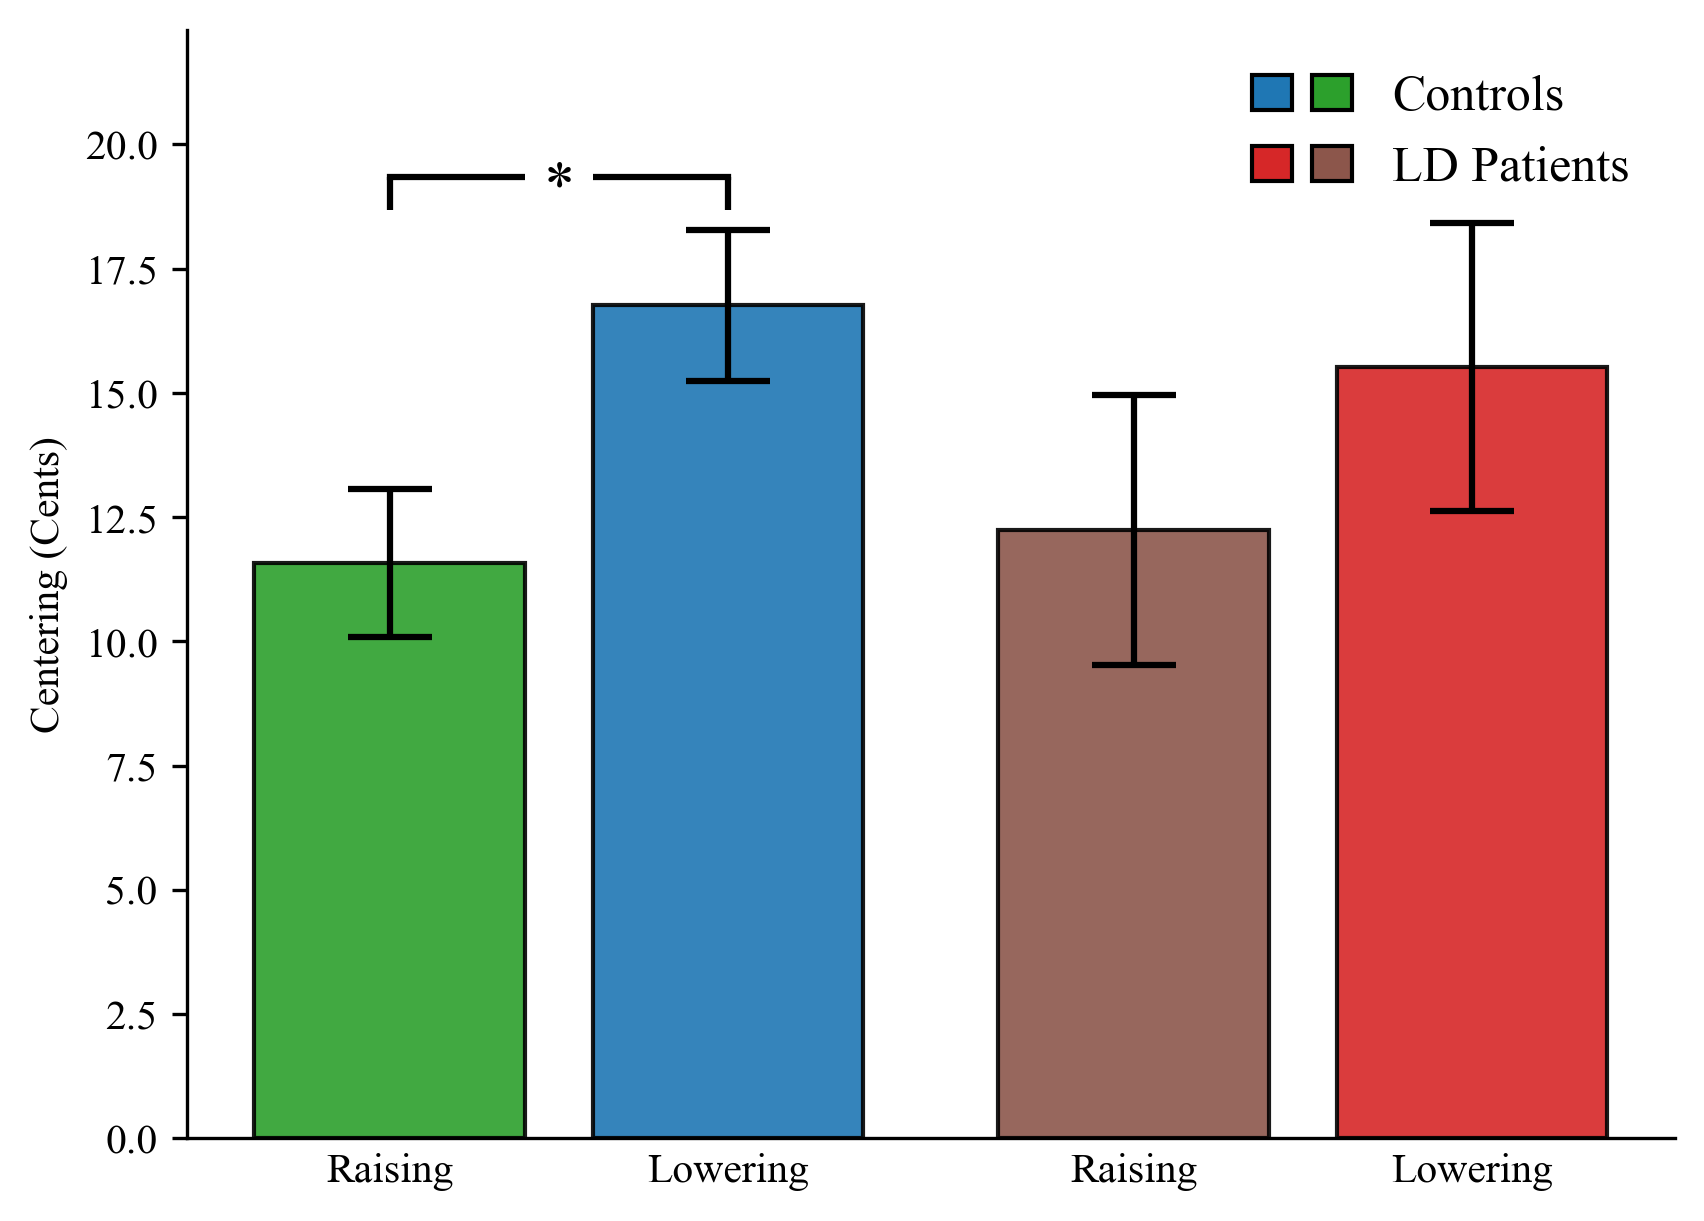

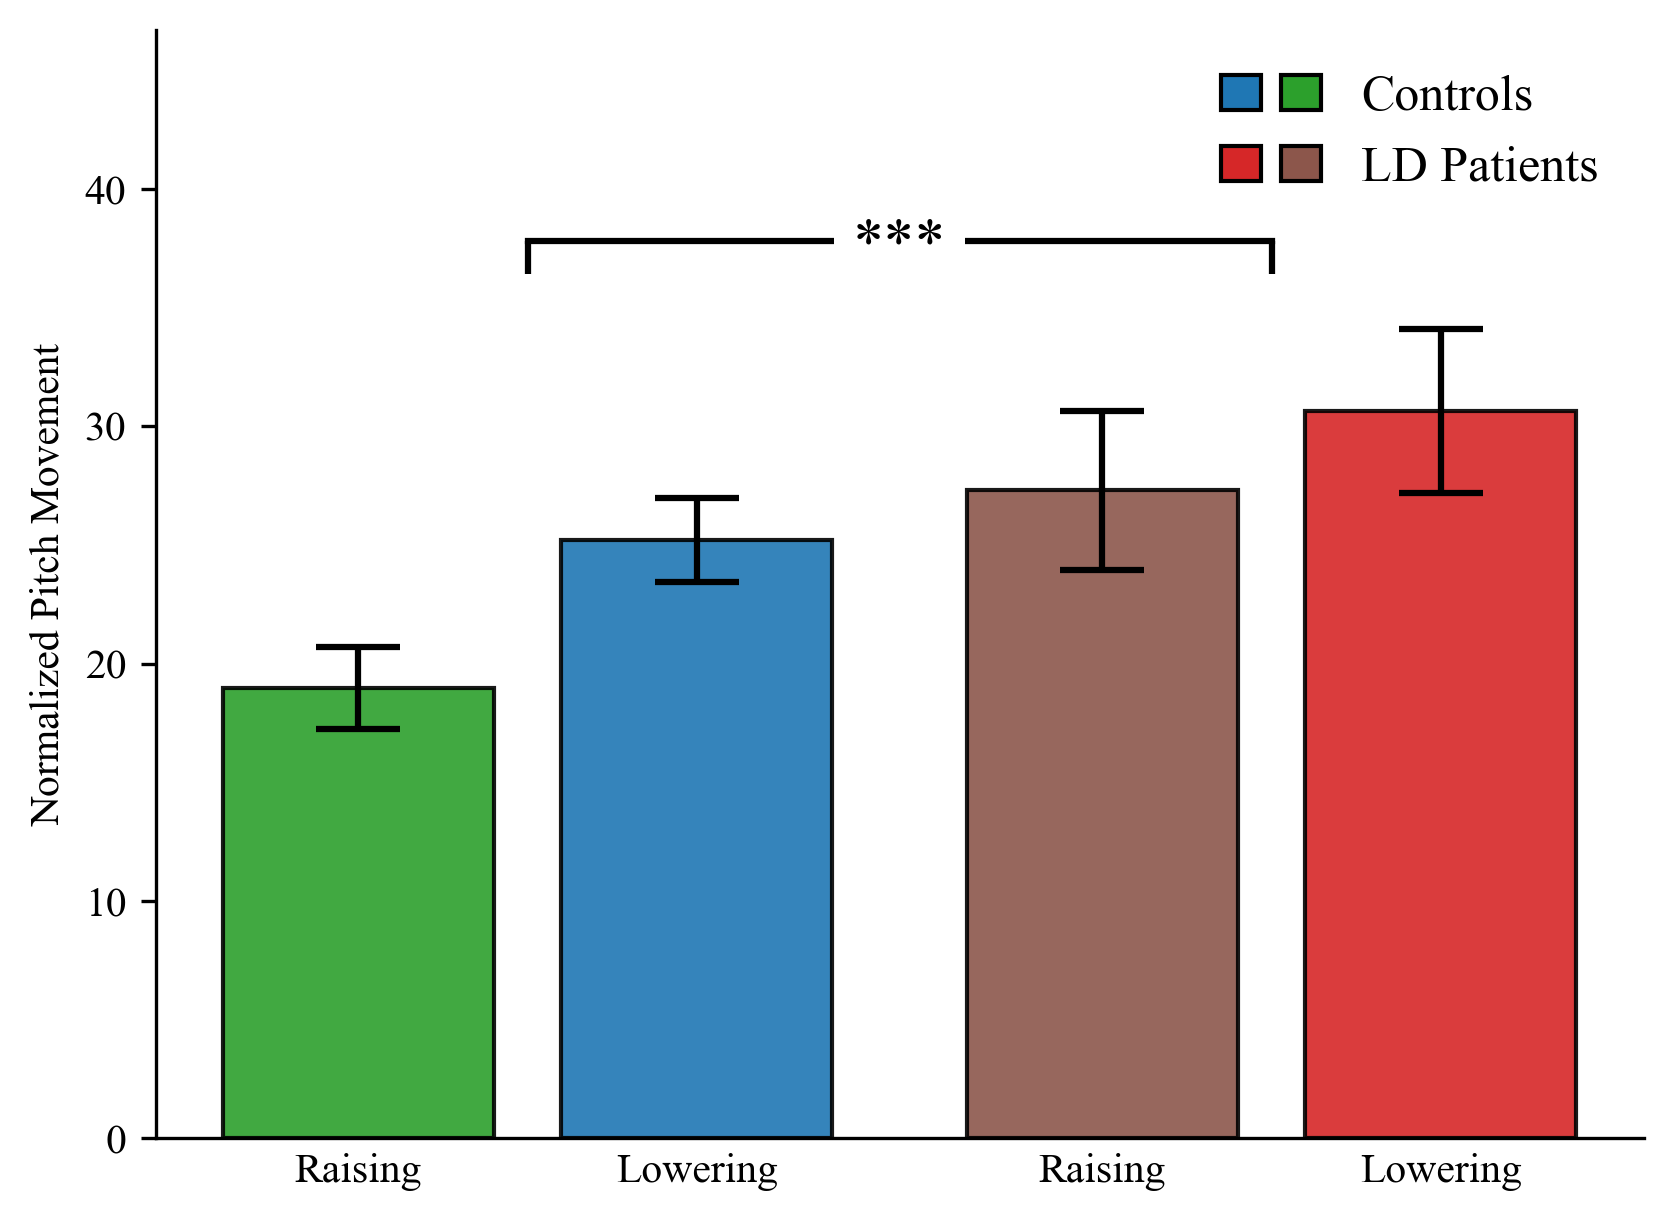

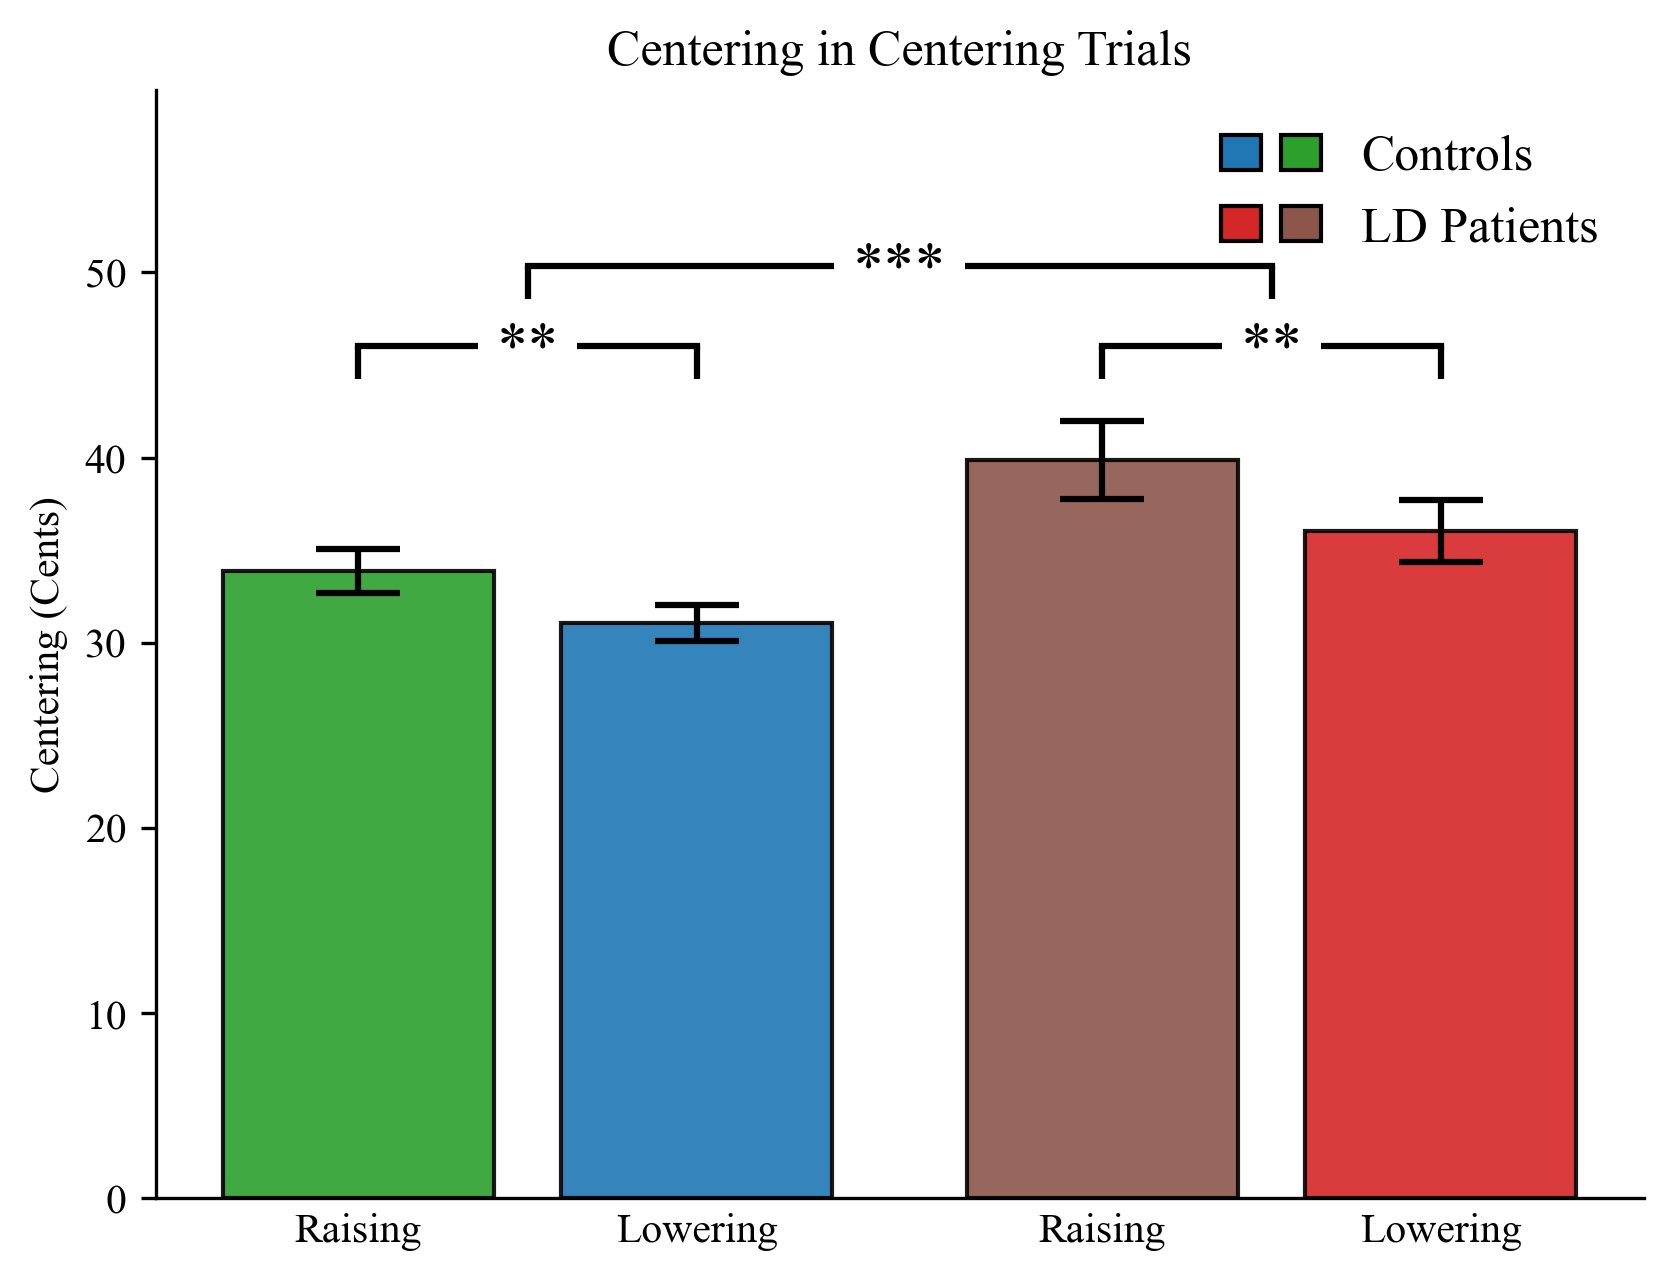

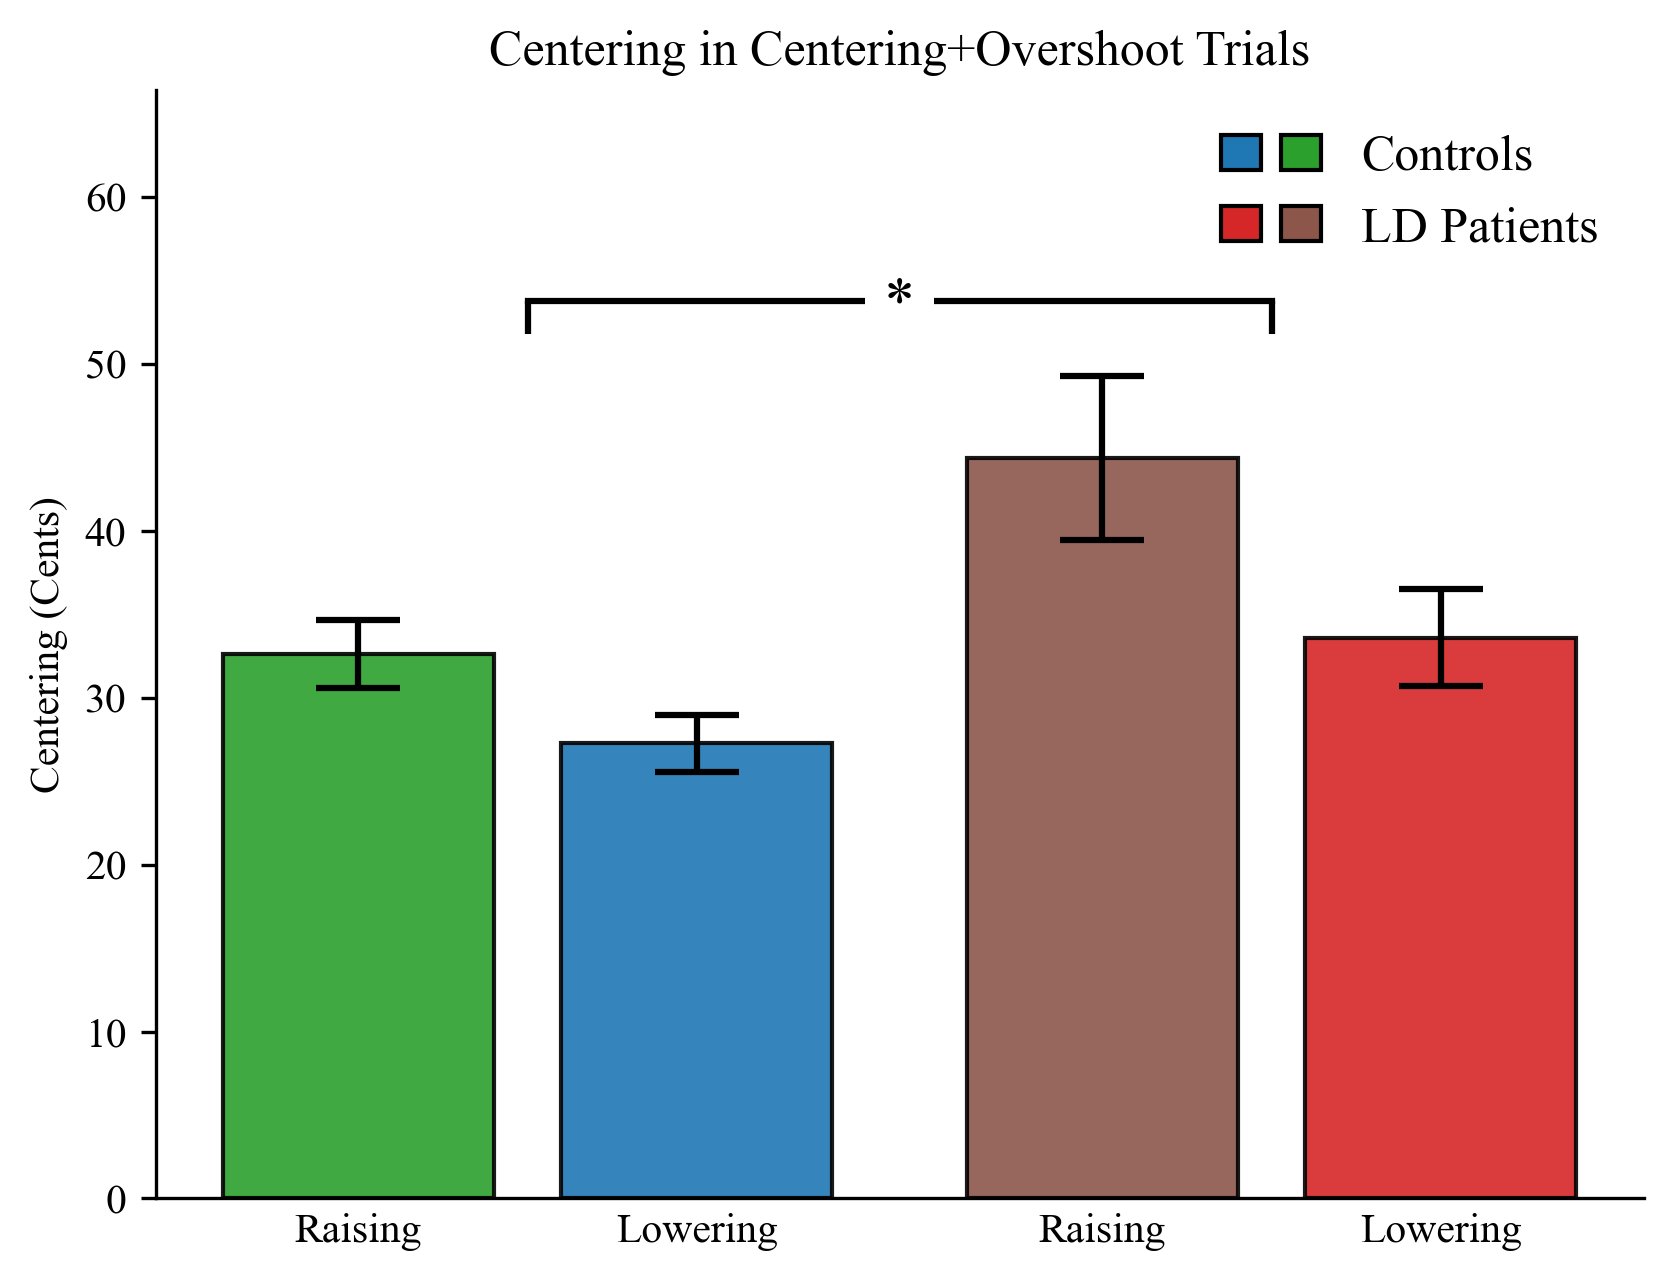

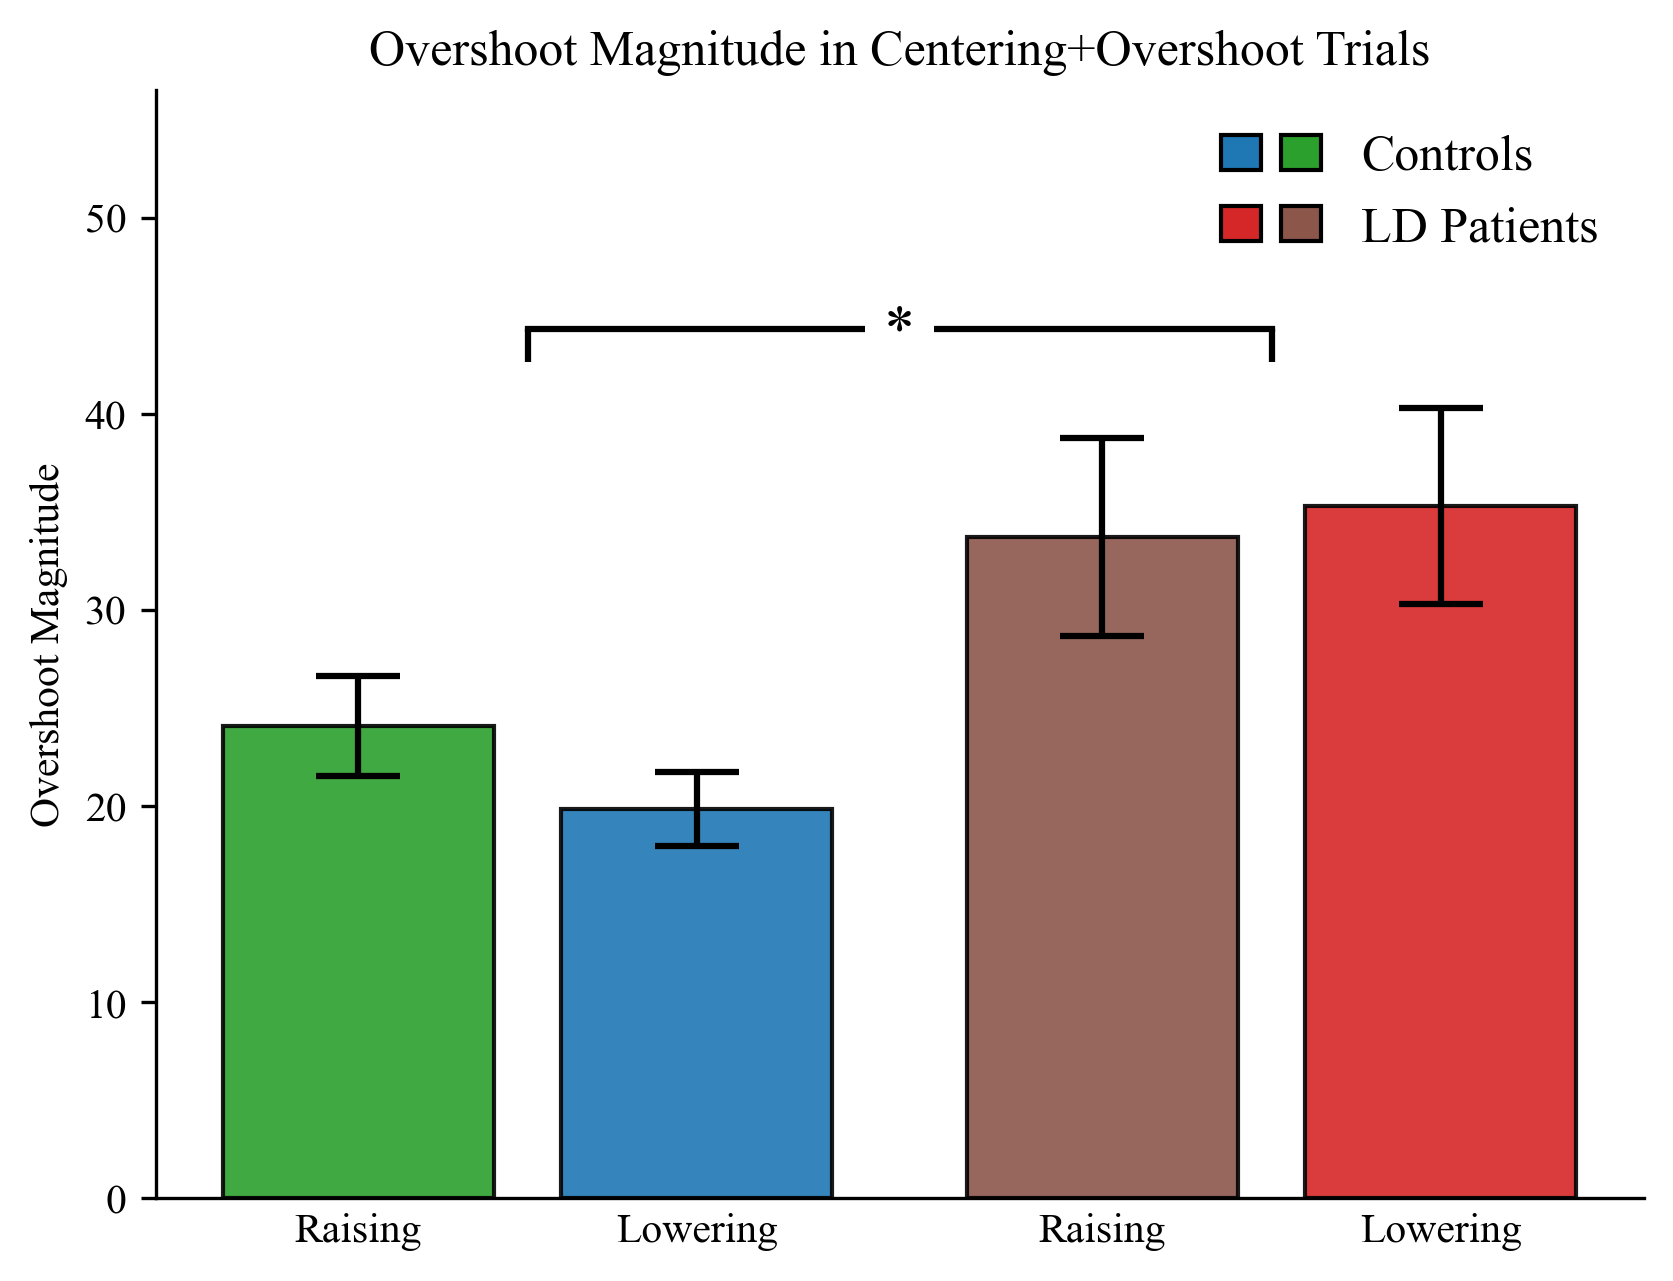

In [5]:
importlib.reload(figure)
matplotlib.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(1, 1, dpi=300)
figure.group_tercile_bars(output_dataset, fig, plot_settings | {
    "label_alias": {
        "UPPER": "Lowering",
        "LOWER": "Raising"
    },
    "bar_spacing": 1.,
    "group_spacing": 0.2
},
                          legend_loc="upper right")

figure.significance_bar(ax, 0, 1, max(ax.get_ylim()), display_string= "*")
ax.set_ylim((0, ax.get_ylim()[1] + 2))

fig, ax = plt.subplots(1, 1, dpi=300)
figure.group_tercile_bars(output_dataset, fig, plot_settings | {
    "label_alias": {
        "UPPER": "Lowering",
        "LOWER": "Raising"
    },
    "bar_spacing": 1.,
    "group_spacing": 0.2
},
                          legend_loc="upper right",
                          quantity_column="Normalized Pitch Movement")

# figure.significance_bar(ax, -0.5, 3.6, max(ax.get_ylim()) + 2, display_string= "***")
figure.significance_bar(ax, 0.5, 2.7, max(ax.get_ylim()) + 2, display_string= "***")
ax.set_ylim((0, ax.get_ylim()[1] + 7))

centering_dataset = output_dataset[output_dataset["Centering Class"] == "Centering"]
fig, ax = plt.subplots(1, 1, dpi=300)
ax.set_title("Centering in Centering Trials")
figure.group_tercile_bars(centering_dataset, fig, plot_settings | {
    "label_alias": {
        "UPPER": "Lowering",
        "LOWER": "Raising"
    },
    "bar_spacing": 1.,
    "group_spacing": 0.2
},
                          legend_loc="upper right")

# figure.significance_bar(ax, -0.5, 3.6, max(ax.get_ylim()) + 2, display_string= "***")
bar_top_height = max(ax.get_ylim()) + 2
figure.significance_bar(ax, 0, 1, bar_top_height, display_string= "**")
figure.significance_bar(ax, 2.2, 3.2, bar_top_height, display_string= "**")
figure.significance_bar(ax, 0.5, 2.7, max(ax.get_ylim()) + 2, display_string= "***")
ax.set_ylim((0, ax.get_ylim()[1] + 7))

overshoot_dataset = centering_dataset[centering_dataset["Overshoot"]].copy()
fig, ax = plt.subplots(1, 1, dpi=300)
ax.set_title("Centering in Centering+Overshoot Trials")
figure.group_tercile_bars(overshoot_dataset, fig, plot_settings | {
    "label_alias": {
        "UPPER": "Lowering",
        "LOWER": "Raising"
    },
    "bar_spacing": 1.,
    "group_spacing": 0.2
},
                          legend_loc="upper right")

# figure.significance_bar(ax, -0.5, 3.6, max(ax.get_ylim()) + 2, display_string= "***")
bar_top_height = max(ax.get_ylim()) + 2
figure.significance_bar(ax, 0.5, 2.7, max(ax.get_ylim()) + 2, display_string= "*")
ax.set_ylim((0, ax.get_ylim()[1] + 10))

overshoot_dataset["Overshoot Magnitude"] = np.abs(overshoot_dataset["Pitch Movement"]) - np.abs(overshoot_dataset["Centering (Cents)"])
fig, ax = plt.subplots(1, 1, dpi=300)
ax.set_title("Overshoot Magnitude in Centering+Overshoot Trials")
figure.group_tercile_bars(overshoot_dataset, fig, plot_settings | {
    "label_alias": {
        "UPPER": "Lowering",
        "LOWER": "Raising"
    },
    "bar_spacing": 1.,
    "group_spacing": 0.2,
},
                          legend_loc="upper right",
                          quantity_column="Overshoot Magnitude")

# figure.significance_bar(ax, -0.5, 3.6, max(ax.get_ylim()) + 2, display_string= "***")
bar_top_height = max(ax.get_ylim()) + 2
figure.significance_bar(ax, 0.5, 2.7, max(ax.get_ylim()) + 2, display_string= "*")
ax.set_ylim((0, ax.get_ylim()[1] + 10))



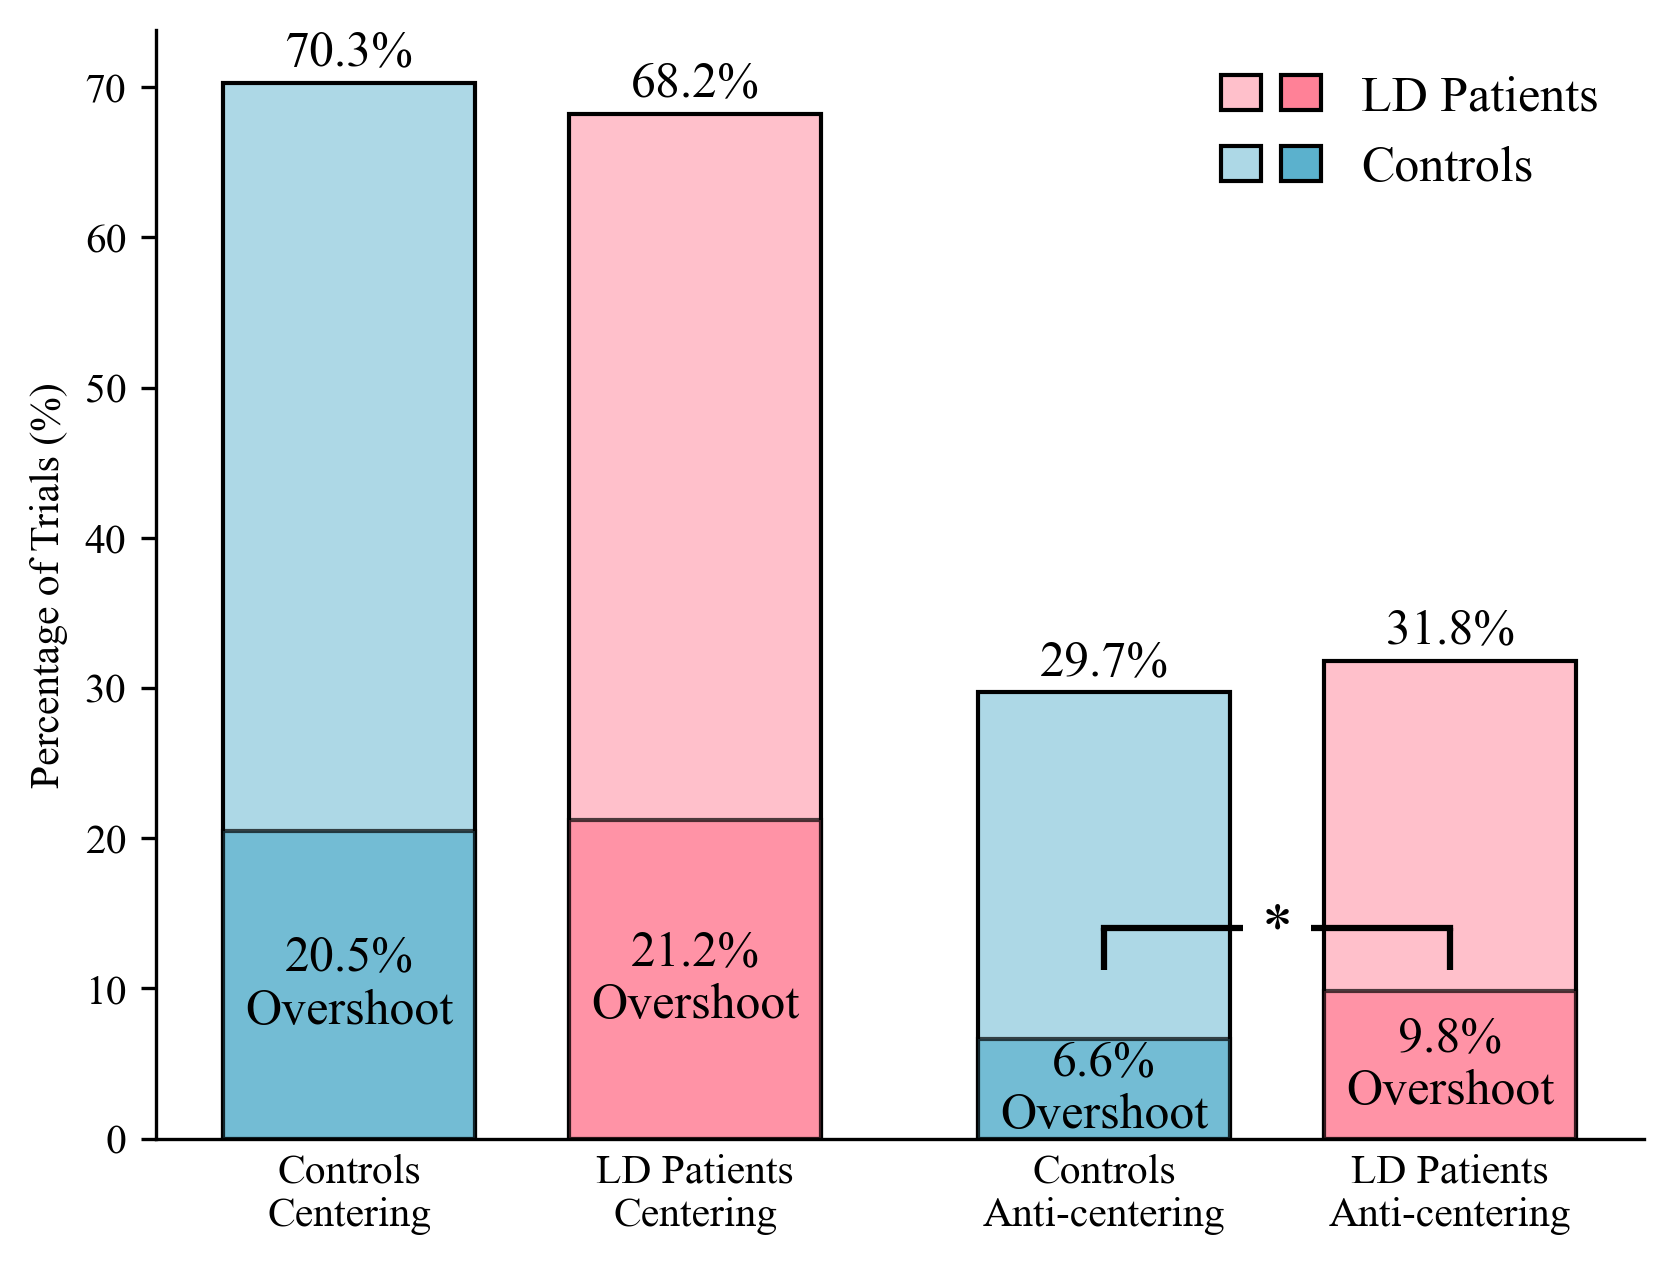

In [6]:
importlib.reload(figure)

output_dataset = pd.read_csv(CACHE_PATH / "peripheral_dataset.csv")
output_dataset["Centering Class"] = (output_dataset["Centering (Cents)"]
                                     .apply(lambda x: "Centering" if x > 0 else "Anti-centering"))
output_dataset["Overshoot"] = np.abs(output_dataset["Pitch Movement"]) > np.abs(output_dataset["Centering (Cents)"])

fig, ax = plt.subplots(1, 1, dpi=300)
figure.group_stacked_bars(output_dataset, fig,
                          plot_settings | {
                                    "plot_order": ["Centering", "Anti-centering"],
                                    "label_alias": {
                                        "UPPER": "Lowering",
                                        "LOWER": "Raising"
                                    },
                                    "colormap": {
                                        "LD Patients": to_rgb("pink"),
                                        "Controls": to_rgb("lightblue")
                                    },
                                    "bar_spacing": 1.1,
                                    "group_spacing": 0.2
                                },
                          legend_loc="upper right",
                          text_offset=2,
                          counts=False)
figure.significance_bar(ax, 2.4, 3.5, 14, display_string= "*", marker_size=10)

centering_dataset = output_dataset[output_dataset["Centering Class"] == "Centering"]


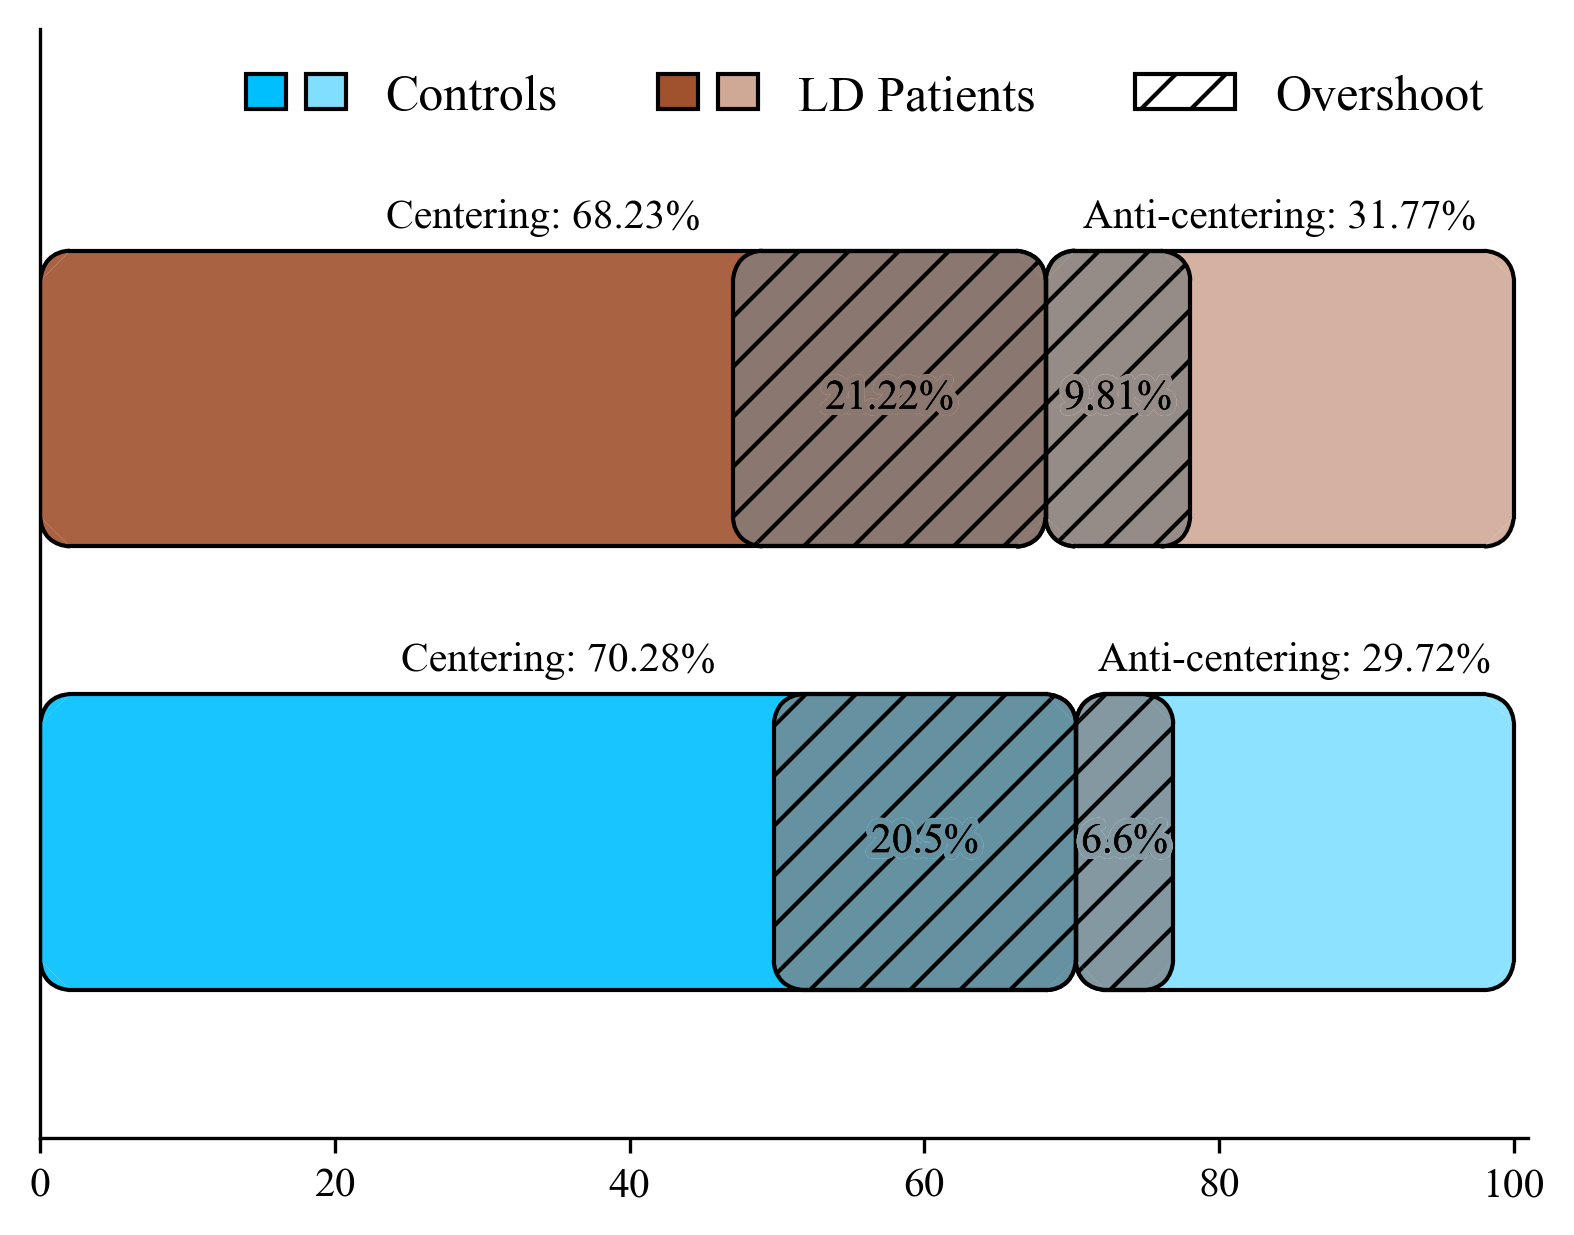

In [9]:
importlib.reload(figure)

output_dataset = pd.read_csv(CACHE_PATH / "peripheral_dataset.csv")
output_dataset["Centering Class"] = (output_dataset["Centering (Cents)"]
                                     .apply(lambda x: "Centering" if x > 0 else "Anti-centering"))
output_dataset["Overshoot"] = np.abs(output_dataset["Pitch Movement"]) > np.abs(output_dataset["Centering (Cents)"])

fig, ax = plt.subplots(1, 1, dpi=300)
figure.group_class_percentage_comparison(output_dataset, fig,
                          plot_settings | {
                                    "plot_order": ["Controls", "LD Patients"],
                                    "colormap": {
                                         "LD Patients": {
                                            "Centering": figure.lighten_color(to_rgb("sienna"), 0),
                                            "Anti-centering": figure.lighten_color(to_rgb("sienna"), 0.5)
                                        },
                                        "Controls": {
                                            "Centering": figure.lighten_color(to_rgb("deepskyblue"), 0),
                                            "Anti-centering": figure.lighten_color(to_rgb("deepskyblue"), 0.5)
                                        },
                                    },
                                    "group_spacing": 0.5,
                                    "border_radius": (2, 0.1),
                                    "secondary_hatch": "//",
                                    "opacity": {
                                        "primary": 0.9,
                                        "secondary": 0.75
                                    },
                                    "text_spacing": 0.05,
                                },
                          )
ax.set_ylim((-0.5, 3.25))
ax.set_xlim((0, 101))

plt.savefig("/Users/anantajit/Downloads/figure.png")